# The Detroit Project
### Applied Data Science Capstone Final Project
**_Author:_** Nikhil Hodarkar  **_Date:_** July 29, 2020

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Analysis](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

**The Business Problem:**
    Like many cities around the United States and the world, Detroit was profoundly impacted economically by the financial crisis of 2008.  In addition to this global shock, Detroit was already in the process of an economic decline over the preceding years and decades.  The Detroit of world renown was an automotive manufacturing superpower, but its peak may be traced back as far as the early 1950’s when the city was the fourth largest city in the United States and home to 1.8 million people.[^1]  Since this peak, people and businesses have left Detroit for a variety of reasons, drastically dropping the total population down to a current level of 670,000.[^2]  The city even experienced a major bankruptcy in 2013.[^3] 
	In the intervening years since the 2008 financial crisis, the city of Detroit has been the subject of several programs to revitalize the city and grow the business community.  These programs were initiated by a variety of prominent organizations and individuals, but despite their tremendous efforts, attracting businesses and people to a city with the economic struggles of Detroit is quite difficult.  Much work still needs to be done to return Detroit to its former vibrancy.
    
**Project Goal:**
    The goal of this particular project is to leverage Foursquare API business data for Detroit and New York City to identify neighborhoods in Detroit that are similar to neighborhoods in New York City.  The similarity of neighborhoods will be determined by the types of businesses in the neighborhoods, as found in the Foursquare database.  Using the “similar neighborhood” results along with some basic demographic information (such as house value and median income), community and business leaders in Detroit can attract businesses and people from specific New York City neighborhoods to their respective “similar” Detroit neighborhoods. 
    
**Target Audience - Interested Parties and Stakeholders:**
    The target audience for this project are the community, political and business leaders of Detroit who are actively engaged in trying to attract new businesses and people to the city.  These leaders would be interested in the results of this project because it can narrow their geographic focus to specific neighborhoods in New York and also give them some good information to convince people and businesses to make the move to specific Detroit neighborhoods.  New York City is one of the most prominent business centers in the world and home to many talented people that would bolster the future of any city.  Due to the population congestion and high cost of living (among other things), people and businesses are moving out of New York City to other cities[^4], including Detroit[^5].  If Detroit leaders can attract more of those business and people, everyone in the city stands to benefit from new economic activity. 

[^1]: From https://en.wikipedia.org/wiki/Demographic_history_of_Detroit

[^2]: From https://en.wikipedia.org/wiki/Detroit

[^3]: From https://en.wikipedia.org/wiki/Detroit

[^4]: Kelly, Jack, “New Yorkers Are Leaving The City In Droves: Here's Why They're Moving And Where They're Going”,  Forbes.com, dated Sept. 5, 2019. https://www.forbes.com/sites/jackkelly/2019/09/05/new-yorkers-are-leaving-the-city-in-droves-heres-why-theyre-moving-and-where-theyre-going/#32201ed741ac

[^5]: Anders, Melissa, “Why moving to Detroit from New York was the 'best decision' for SPLT”, Model D, dated Oct. 24, 2016.  https://www.modeldmedia.com/features/splt-detroit-102416.aspx

## Data <a name="data"></a>

**Geolocation Data:**
Neighborhood names and latitude/longitude pairs for Detroit were scraped from https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Detroit, and the corresponding information for New York were obtained from https://geo.nyu.edu/catalog/nyu_2451_34572.  For Detroit, some of the neighborhoods listed by Wikipedia lacked geolocation data and were removed.  This is fine for the purposes of this project, as most of those neighborhoods seemed relatively minor.  In total, this project analyzed 49 neighborhoods in Detroit and 306 neighborhoods in New York City. 


**Foursquare API Data:**
    The Foursquare API provides a variety of data about venues visited by Foursquare app users.   Using the geolocation data for the neighborhoods, the Foursquare API was queried to provide information on venues within 500 meters of latitude and longitude coordinates of the neighborhoods, with a limit of 100 venues per neighborhood.  The data that used for clustering analysis was the category of each venue.  Between the Detroit and New York neighborhoods, there are 436 venue categories which can be used to cluster the neighborhoods.  The K-means clustering is based on the frequency of venue types in each neighborhood on the belief that a successful business in a New York neighborhood can also be successful in a Detroit neighborhood of the same cluster.  

**Demographic Data:**
	In addition to the Foursquare-based clustering analysis, demographic data on the selected cluster neighborhoods was obtained via zip codes.  First, openstreetmap.org’s Nominatim API was used to convert latitude and longitude data into zip code data.  Once each of the selected neighborhoods had a zip code associated with it, the zip code information was used to obtain census-type data from CDX Technologies at https://www.cdxtech.com/tools/demographicdata/.  The returned data file includes dozens of demographic data fields for each zip code, but only the following attributes were analyzed: ‘Median Age’, ‘Median Age Female’, ‘Median Age Male’, ‘Persons Per Households’, ‘Household Median Income’ and ‘Median House Value’.

The following code block imports substantially all of the libraries used in this project.  A few specific libraries are imported later in this notebook.

In [2]:
# Importing Libraries
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup # library for handling difficult webscraping
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import re # for parsing regular expressions

print('Libraries imported.')

Libraries imported.


**Get Detroit neighborhood and longitude/latitude data from Wikipedia and store in CSV**

First, let's pull the tables from Wikipedia using pandas.  The 'Location' field in these Wikipedia tables has text and also the latitude/longitude coordinates of the various Detroit neighborhoods.  In the second step, the regular expression Python library is used to extract the latitude/longitude pairs where available.  Finally, the data frame of Detroit neighborhoods is reduced to only those with valid latitude and longitude pairs.

In [3]:
# Pull Detroit Neighborhood information from Wikipedia using pandas
temp = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Detroit', header=0)

In [4]:
# Create Dataframe for Detroit Neighborhoods
boroughs = ['Downtown', 'Midtown', 'New Center', 'North', 'East Upper', 'East Central', 'East Lower', 'West North', 'West Central', 'Southwest']
cols = ['Name','Image','Location','Summary']

i = 1
while (i <= len(boroughs)):
    temp_df = pd.DataFrame(temp[i], columns=cols)
    temp_df.drop(columns=['Image','Summary'], inplace=True)
    temp_df['Borough'] = boroughs[i-1]
    #temp_df['Latitude'] = np.nan
    #temp_df['Longitude'] = np.nan
    temp_df.rename(columns={"Name":"Neighborhood"}, inplace=True)
    #temp_df = temp_df[['Borough', 'Neighborhood', 'Location', 'Latitude', 'Longitude']]
    if (i==1):
        Detroit = temp_df
    else:
        Detroit = Detroit.append(temp_df, ignore_index=True)
    i += 1

Detroit.dropna(axis=0, inplace=True)
Detroit['Latitude'] = np.nan
Detroit['Longitude'] = np.nan
Detroit['City'] = 'Detroit'
Detroit = Detroit[['City', 'Borough', 'Neighborhood', 'Location', 'Latitude', 'Longitude']]
Detroit.reset_index(inplace=True, drop=True)
Detroit.head()

,City,Borough,Neighborhood,Location,Latitude,Longitude
0,Detroit,Downtown,Bricktown Historic District,Separates the Renaissance Center from Greektown.,NaN,NaN
1,Detroit,Downtown,Broadway Avenue Historic District,Broadway between Gratiot and Grand River Boule...,NaN,NaN
2,Detroit,Downtown,Campus Martius Park,42°19′53″N 83°2′48″W﻿ / ﻿42.33139°N 83.04667°W...,NaN,NaN
3,Detroit,Downtown,Capitol Park Historic District,"Roughly bounded by Grand River Ave., Woodward ...",NaN,NaN
4,Detroit,Downtown,Detroit Financial District,Bounded by Woodward and Jefferson and Lafayett...,NaN,NaN


The following code block is the step where the geocoordinates are extracted using "findall", and where they don't exist the values are set to 0.  After the coordinates are extracted, the rows with 0 values are dropped.

In [5]:
det_temp = Detroit

# For-loop uses regular expression tools to extract latitude and longitude from 'Location' column
# Not all neighborhoods have Lat/Long listed, so set those to 0 to remove in next step

for i in range(det_temp.shape[0]):
    location_string = det_temp.loc[i,'Location']
    
    if(location_string):
        Lat = re.findall('[4][0-9].[0-9][0-9][0-9][0-9][0-9]', location_string)
        Lng = re.findall('[8][0-9].[0-9][0-9][0-9][0-9][0-9]', location_string)

        if (bool(Lat)):
            Latc = float(Lat[0])
            det_temp.loc[i, 'Latitude'] = Latc
        else:
            det_temp.loc[i, 'Latitude'] = 0
        
        if (bool(Lng)):
            Lngc = -float(Lng[0])
            det_temp.loc[i, 'Longitude'] = Lngc
        else:
            det_temp.loc[i, 'Longitude'] = 0
      
        
    else:
        pass
    
det_temp.head()


,City,Borough,Neighborhood,Location,Latitude,Longitude
0,Detroit,Downtown,Bricktown Historic District,Separates the Renaissance Center from Greektown.,0.00000,0.00000
1,Detroit,Downtown,Broadway Avenue Historic District,Broadway between Gratiot and Grand River Boule...,42.33500,-83.04611
2,Detroit,Downtown,Campus Martius Park,42°19′53″N 83°2′48″W﻿ / ﻿42.33139°N 83.04667°W...,42.33139,-83.04667
3,Detroit,Downtown,Capitol Park Historic District,"Roughly bounded by Grand River Ave., Woodward ...",42.33278,-83.04944
4,Detroit,Downtown,Detroit Financial District,Bounded by Woodward and Jefferson and Lafayett...,42.32954,-83.04734


In [6]:
# Remove neighborhoods without latitude/longitude from Wikipedia

reduced_det = det_temp[det_temp.Latitude != 0]
reduced_det.reset_index(inplace=True, drop=True)

In [7]:
# Drop 'Location' column

Detroit_df = reduced_det.drop(columns=['Location'])
Detroit_df.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,Detroit,Downtown,Broadway Avenue Historic District,42.33500,-83.04611
1,Detroit,Downtown,Campus Martius Park,42.33139,-83.04667
2,Detroit,Downtown,Capitol Park Historic District,42.33278,-83.04944
3,Detroit,Downtown,Detroit Financial District,42.32954,-83.04734
4,Detroit,Downtown,Grand Circus Park Historic District,42.33611,-83.05056


**Extract New York Neighborhood Data**

*NOTE: New York data was downloaded from NYU, at  https://geo.nyu.edu/catalog/nyu_2451_34572*

In [8]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['City', 'Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_df = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_df = NY_df.append({'City': 'New York',
                          'Borough': borough,
                          'Neighborhood': neighborhood_name,
                          'Latitude': neighborhood_lat,
                          'Longitude': neighborhood_lon}, ignore_index=True)
    
NY_df.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


**In the final step for the geocoordinates, combine the Detroit and New York neighborhoods into a single dataframe**

In [9]:
# Combine Detroit and New York neighborhoods into a single dataframe
Combo_df = pd.concat([Detroit_df, NY_df], axis=0, ignore_index=True)

In [10]:
Combo_df.head(10)

,City,Borough,Neighborhood,Latitude,Longitude
0,Detroit,Downtown,Broadway Avenue Historic District,42.33500,-83.04611
1,Detroit,Downtown,Campus Martius Park,42.33139,-83.04667
2,Detroit,Downtown,Capitol Park Historic District,42.33278,-83.04944
3,Detroit,Downtown,Detroit Financial District,42.32954,-83.04734
4,Detroit,Downtown,Grand Circus Park Historic District,42.33611,-83.05056
5,Detroit,Downtown,Greektown,42.33500,-83.04222
6,Detroit,Downtown,Lower Woodward Avenue Historic District,42.33417,-83.04889
7,Detroit,Downtown,Monroe Avenue Commercial Buildings,42.33278,-83.04583
8,Detroit,Downtown,Park Avenue Historic District,42.33667,-83.06361
9,Detroit,Downtown,Randolph Street Commercial Buildings Historic ...,42.33444,-83.04500


In [11]:
Combo_df.tail(10)

,City,Borough,Neighborhood,Latitude,Longitude
345,New York,Brooklyn,Madison,40.609378,-73.948415
346,New York,Bronx,Bronxdale,40.852723,-73.861726
347,New York,Bronx,Allerton,40.865788,-73.859319
348,New York,Bronx,Kingsbridge Heights,40.870392,-73.901523
349,New York,Brooklyn,Erasmus,40.646926,-73.948177
350,New York,Manhattan,Hudson Yards,40.756658,-74.000111
351,New York,Queens,Hammels,40.587338,-73.805530
352,New York,Queens,Bayswater,40.611322,-73.765968
353,New York,Queens,Queensbridge,40.756091,-73.945631
354,New York,Staten Island,Fox Hills,40.617311,-74.081740


In [12]:
print("The total number of neighborhoods in this dataframe is: ", Combo_df.shape[0])

The total number of neighborhoods in this dataframe is:  355


## Methodology <a name="methodology"></a>

**Overview:**
This project and its analysis entailed (i) collecting latitude and longitude data on neighborhoods in both Detroit and New York City, (ii) using that geographical data to collect information through the Foursquare API on business types in those neighborhoods and (iii) using a K-means clustering algorithm to cluster the neighborhoods based on their respective business types.  K-means clustering is an algorithm that takes a set of data points and a specified number of clusters and partitions those data points into that number of clusters.  The algorithm attempts to minimize the squared “distance” from the cluster data points to the center of the cluster.  In a simple version in 2-D space, the distance could be physical distance on a geographical map.  In this case, the “distance” is along the Foursquare “Venue Category” space, which has 436 dimensions.  The algorithm doesn’t guarantee an optimal solution, but it should yield clusters where the neighborhoods have a substantially similar “Venue Category” nature. 
After clusters containing both Detroit and New York neighborhoods were identified, additional demographic information was obtained on those neighborhoods using zip code data.  The combined data was then used to analyze the clusters.

K-means algorithm description from https://en.wikipedia.org/wiki/K-means_clustering

**Step 1 – Get Foursquare API Venue Information for each Neighborhood:** 
In the first step, the data frame containing each neighborhood and its respective latitude and longitude coordinates was used to make an “explore” query to the Foursquare API.  The Foursquare API returned venues within 500 meters of the listed coordinates, up to a limit of 100 venues per neighborhood.  In total, 11,841 venues were returned.

**Foursquare API Data acquisition**

*Get Venue information for all of the neighborhoods through Foursquare API*

*In the two cells below, the Foursquare API call function is defined.  A separate file with my credentials was imported to keep them secret.*

In [13]:
# Import private module to keep Foursquare credentials secure
import Get4SquareCred as g4sc
CLIENT_ID, CLIENT_SECRET = g4sc.GetMyCred()
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 100

In [14]:
# Function to get specified number of venues within a given radius of a neighborhood, based on its latiude/longitude

def getNearbyVenues(cities, boroughs, names, latitudes, longitudes, CLIENT_ID, CLIENT_SECRET, VERSION, radius, LIMIT):
    
    venues_list=[]
    for city, borough, name, lat, lng in zip(cities, boroughs, names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**The block of code in the cell below made the call to the Foursquare API one time.  Due to the size of the call the time it takes, the call was only made once and the results saved to a CSV file.  For subsequent versions of this notebook, the CSV file was used to load the data.**

In [86]:
# Get list of venues for all neighborhoods
Venues_df = getNearbyVenues(cities=Combo_df['City'],
                            boroughs=Combo_df['Borough'],
                            names=Combo_df['Neighborhood'],
                            latitudes=Combo_df['Latitude'],
                            longitudes=Combo_df['Longitude'],
                            CLIENT_ID=CLIENT_ID,
                            CLIENT_SECRET=CLIENT_SECRET,
                            VERSION=VERSION,
                            radius=radius,
                            LIMIT=LIMIT
                            )

In [19]:
# The following commented line of code saved the CSV file one time
# Venues_df.to_csv('Venues_20200720.csv', index=False)

*Retrieve the Foursquare API data from a saved file and display the first 10 rows*

In [15]:
Venues_df = pd.read_csv('Venues_20200720.csv')
Venues_df.head(10)

,City,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,The Belt,42.334386,-83.046087,Art Gallery
1,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,Vault of Midnight,42.334135,-83.046621,Comic Shop
2,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,The Standby,42.334439,-83.046009,New American Restaurant
3,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,Madcap Coffee,42.334530,-83.048220,Coffee Shop
4,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,Vicente's Cuban Cuisine,42.334436,-83.047193,Cuban Restaurant
5,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,Shinola Hotel,42.334168,-83.048365,Hotel
6,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,7 Greens,42.334094,-83.046444,Salad Place
7,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,Evening Bar,42.334454,-83.048172,Bar
8,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,Queen's,42.334413,-83.047730,Bar
9,Detroit,Downtown,Broadway Avenue Historic District,42.335,-83.04611,Wright & Co.,42.335000,-83.049230,Cocktail Bar


In [16]:
# Grouping the Dataframe by city, borough and neighborhood was useful to get a sense of the results
# Below is a view of the head of that groupby result
Venues_df.groupby(['City', 'Borough', 'Neighborhood']).count().head()

Neighborhood Latitude  \
City    Borough  Neighborhood                                                 
Detroit Downtown Broadway Avenue Historic District                      100   
                 Campus Martius Park                                    100   
                 Capitol Park Historic District                         100   
                 Detroit Financial District                             100   
                 Grand Circus Park Historic District                     75   

                                                      Neighborhood Longitude  \
City    Borough  Neighborhood                                                  
Detroit Downtown Broadway Avenue Historic District                       100   
                 Campus Martius Park                                     100   
                 Capitol Park Historic District                          100   
                 Detroit Financial District                              100   
                 Grand Circus Park Historic District                      75   

                                                      Venue  Venue Latitude  \
City    Borough  Neighborhood                                                 
Detroit Downtown Broadway Avenue Historic District      100             100   
                 Campus Martius Park                    100             100   
                 Capitol Park Historic District         100             100   
                 Detroit Financial District             100             100   
                 Grand Circus Park Historic District     75              75   

                                                      Venue Longitude  \
City    Borough  Neighborhood                                           
Detroit Downtown Broadway Avenue Historic District                100   
                 Campus Martius Park                              100   
                 Capitol Park Historic District                   100   
                 Detroit Financial District                       100   
                 Grand Circus Park Historic District               75   

                                                      Venue Category  
City    Borough  Neighborhood                                         
Detroit Downtown Broadway Avenue Historic District               100  
                 Campus Martius Park                             100  
                 Capitol Park Historic District                  100  
                 Detroit Financial District                      100  
                 Grand Circus Park Historic District              75

**Step 2 – Create Dummy Variable Data Frame for All Unique Venue Types:**
In the second step, each unique “Venue Category” value was turned into a column in a data frame that is essentially a matrix of dummy variables for each venue/neighborhood combination.  Next, the data frame is grouped by neighborhood, with each venue category having a value equal to the mean of all the dummy variables in that category for that neighborhood.  For example, if a neighborhood had 100 venues returned from Foursquare and 20 of them were in the “Arcade” category, that category would have a value of 0.2.  This matrix of means are what was used to do the K-means clustering analysis. 

*The code in the cell block below converts the venue category information into dummy variables to be used for Kmeans clustering.*

In [17]:
# one hot encoding
venues_onehot = pd.get_dummies(Venues_df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ven_col = list(venues_onehot.columns[:])
ven_col.remove('Neighborhood')
venues_onehot['Neighborhood'] = Venues_df['Neighborhood']
venues_onehot['Borough'] = Venues_df['Borough']
venues_onehot['City'] = Venues_df['City']

# move neighborhood column to the first column
ven_col.insert(0, 'Neighborhood')
ven_col.insert(0, 'Borough')
ven_col.insert(0, 'City')
venues_onehot = venues_onehot[ven_col]

venues_onehot.head()

,City,Borough,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Country Dance Club,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,News

In [18]:
venues_onehot.shape

(11841, 439)

**Now we do the critical step of creating the dataframe matrix of means that will be used by the K-means clustering algorithm.**

In [19]:
# Group the dataframe by city, borough and neighborhood, using the means of each venue category column

venues_grouped = venues_onehot.groupby(['City', 'Borough', 'Neighborhood']).mean().reset_index()
venues_grouped.head()

,City,Borough,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Country Dance Club,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,News

**Step 3 – Identify Top 10 Venues of Each Neighborhood:**
	Before doing the clustering analysis, we can use the matrix of venue category means to identify the top 10 venues for each neighborhood, based on frequency of venue type.  This information will be used in the “Results and Analysis” section.  

**Describe Neighborhoods by Top Ten Venues**

In [20]:
# This function returns top venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Set top venues to 10
num_top_venues = 10

# create columns according to number of top venues
columns = ['City', 'Borough', 'Neighborhood']

indicators = ['st', 'nd', 'rd']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']
neighborhoods_venues_sorted['Borough'] = venues_grouped['Borough']
neighborhoods_venues_sorted['City'] = venues_grouped['City']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 3:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,City,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Detroit,Downtown,Broadway Avenue Historic District,Coffee Shop,Lounge,Hotel,Bar,Burger Joint,Pizza Place,Park,American Restaurant,Cocktail Bar,New American Restaurant
1,Detroit,Downtown,Campus Martius Park,Coffee Shop,Cocktail Bar,American Restaurant,Bar,Steakhouse,New American Restaurant,Lounge,Sandwich Place,Hotel,Restaurant
2,Detroit,Downtown,Capitol Park Historic District,Coffee Shop,Cocktail Bar,American Restaurant,Hotel,Restaurant,New American Restaurant,Sandwich Place,Lounge,Thai Restaurant,Steakhouse
3,Detroit,Downtown,Detroit Financial District,Coffee Shop,Sandwich Place,Restaurant,Hotel,Café,American Restaurant,Steakhouse,New American Restaurant,Pizza Place,Diner
4,Detroit,Downtown,Grand Circus Park Historic District,Coffee Shop,Hotel,Bar,Lounge,New American Restaurant,Jazz Club,Park,Cocktail Bar,Sports Bar,Music Venue


**Step 4 – Use Elbow Method to Identify an Acceptable Number of Clusters:**
The elbow method was used to determine the optimal number of clusters, however, a true optimal number was not identified.  Rather, the sum of squared distances between the data points and the cluster centers (the “inertia”) continued to decrease in an approximately linear fashion without a clear inflection point.  The elbow method is a heuristic algorithm that charts the inertia of each K-means cluster set so that a person can visually identify an inflection point where additional clusters decrease the inertia far less than previous increases in the number of clusters.   The method gets its name from the elbow shape it is supposed to have at the inflection point, which does not always occur.

Elbow method information from https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

### K-means Clustering Analysis ###

**Use Elbow Method the inertia metric to determine the optimal number of clusters to use**

*Inertia: the sum of squared distances from data points to their respective cluster centers*

In [21]:
inertias = [] 

K = range(10,101, 10) # From prior analysis, small clusters weren't optimal so start at 10

venues_grouped_clustering = venues_grouped.drop(columns=['City', 'Borough', 'Neighborhood'])  
    
for k in K: 
    #Building and fitting the model 
    kmeans = KMeans(n_clusters=k, random_state=0).fit(venues_grouped_clustering)     

    inertias.append(kmeans.inertia_)

*Chart Elbow Graph*

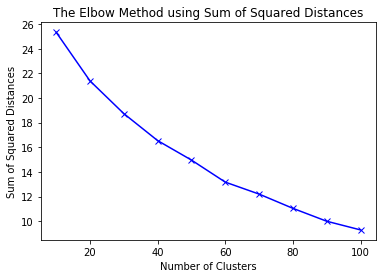

In [22]:
# Plot Elbow Graph using Inertia
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Number of Clusters') 
plt.ylabel('Sum of Squared Distances') 
plt.title('The Elbow Method using Sum of Squared Distances') 
plt.show() 

**ANALYSIS:** The elbow method above did not yield the desired inflection point to optimize the number of clusters.  A level of 100 clusters was chosen because the clusters appeared well formed and 3 clusters included both Detroit and New York neighborhoods.  Increasing clusters would decrease inertias, but likely would result in all Detroit and New York neighborhoods being in separate clusters at some point.  A level of 100 appears to work for the purposes of this project.

## Results and Analysis <a name="results"></a>

**Overall Cluster Results:**
	The results of the K-means cluster analysis yielded 3 clusters that contained both Detroit and New York neighborhoods.  These are clusters numbered 23, 44 and 78, which are the focus of this project.  

In [23]:
# add clustering labels
#neighborhoods_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)  ##NOTE: COMMENT THIS OUT ON FIRST RUN!!
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)  

elbow_merged = Combo_df

# merge to add latitude/longitude, borough and postal code for each neighborhood
elbow_merged = elbow_merged.join(neighborhoods_venues_sorted.set_index(['City', 'Borough', 'Neighborhood']), on=['City', 'Borough', 'Neighborhood'])
elbow_merged.reset_index(inplace=True, drop=True)

**Select Clusters containing both Detroit and New York neighborhoods**

The groupby result below was used to identify the clusters manually, and a snapshot of the head is shown for reference

*Group by Clusters & City*

In [121]:
# The following groupby display was used to identify the clustes with both Detroit and New York neighborhoods
# The only clusters meeting that criteria were 23, 44 and 78
# Only the head of the groupby is shown due to the number of rows
elbow_merged.groupby(['City', 'Cluster Labels']).count().head(5)

Borough  Neighborhood  Latitude  Longitude  \
City    Cluster Labels                                               
Detroit 5.0                   1             1         1          1   
        13.0                  1             1         1          1   
        23.0                  9             9         9          9   
        25.0                  1             1         1          1   
        26.0                  1             1         1          1   

                        1st Most Common Venue  2nd Most Common Venue  \
City    Cluster Labels                                                 
Detroit 5.0                                 1                      1   
        13.0                                1                      1   
        23.0                                9                      9   
        25.0                                1                      1   
        26.0                                1                      1   

                        3rd Most Common Venue  4th Most Common Venue  \
City    Cluster Labels                                                 
Detroit 5.0                                 1                      1   
        13.0                                1                      1   
        23.0                                9                      9   
        25.0                                1                      1   
        26.0                                1                      1   

                        5th Most Common Venue  6th Most Common Venue  \
City    Cluster Labels                                                 
Detroit 5.0                                 1                      1   
        13.0                                1                      1   
        23.0                                9                      9   
        25.0                                1                      1   
        26.0                                1                      1   

                        7th Most Common Venue  8th Most Common Venue  \
City    Cluster Labels                                                 
Detroit 5.0                                 1                      1   
        13.0                                1                      1   
        23.0                                9                      9   
        25.0                                1                      1   
        26.0                                1                      1   

                        9th Most Common Venue  10th Most Common Venue  
City    Cluster Labels                                                 
Detroit 5.0                                 1                       1  
        13.0                                1                       1  
        23.0                                9                       9  
        25.0                                1                       1  
        26.0                                1                       1

**Cluster 23:** a full display of the cluster and top ten venues

In [26]:
elbow_merged.loc[elbow_merged['Cluster Labels'] == 23, elbow_merged.columns[[0,1,2] + list(range(6, elbow_merged.shape[1]))]]

,City,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Detroit,Midtown,Cass-Davenport Historic District,American Restaurant,Bar,Concert Hall,Restaurant,Diner,Music Venue,Chinese Restaurant,Brewery,Tapas Restaurant,Leather Goods Store
14,Detroit,Midtown,Cultural Center Historic District,American Restaurant,Café,Pizza Place,Art Museum,Fast Food Restaurant,History Museum,Boutique,Chinese Restaurant,Shoe Store,Convenience Store
15,Detroit,Midtown,East Ferry Avenue Historic District,Café,Boutique,Art Museum,Sandwich Place,Pizza Place,History Museum,Train,Bank,Bar,Bed & Breakfast
16,Detroit,Midtown,Midtown Woodward Historic District,Concert Hall,Bar,Chinese Restaurant,Deli / Bodega,Hockey Arena,Shipping Store,Roller Rink,Brewery,Locksmith,New American Restaurant
17,Detroit,Midtown,University-Cultural Center,Café,Pizza Place,Sandwich Place,American Restaurant,Boutique,Diner,Fast Food Restaurant,Bookstore,Art Museum,Sushi Restaurant
18,Detroit,Midtown,Warren-Prentis Historic District,Brewery,American Restaurant,Art Gallery,Bar,Café,Clothing Store,Pizza Place,Furniture / Home Store,Sandwich Place,Gift Shop
19,Detroit,Midtown,Wayne State University,American Restaurant,Art Gallery,Bar,Brewery,Yoga Studio,Clothing Store,Sandwich Place,Furniture / Home Store,Pizza Place,Café
20,Detroit,Midtown,West Canfield Historic District,Gift Shop,Bar,Brewery,Clothing Store,American Restaurant,Furniture / Home Store,Liquor Store,Boutique,Café,Italian Restaurant
21,Detroit,Midtown,Willis-Selden Historic District,American Restaurant,Bar,Brewery,Yoga Studio,Music Venue,Gift Shop,Furniture / Home Store,Liquor Store,Boutique,Mediterranean Restaurant
116,New York,Brooklyn,Red Hook,Seafood Restaurant,Art Gallery,American Restaurant,Park,Bar,Flower Shop,Pizza Place,Café,Farm,Wine Shop


**Cluster 44:** a full display of the cluster and top ten venues

In [27]:
elbow_merged.loc[elbow_merged['Cluster Labels'] == 44, elbow_merged.columns[[0,1,2] + list(range(6, elbow_merged.shape[1]))]]

,City,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Detroit,Downtown,Broadway Avenue Historic District,Coffee Shop,Lounge,Hotel,Bar,Burger Joint,Pizza Place,Park,American Restaurant,Cocktail Bar,New American Restaurant
1,Detroit,Downtown,Campus Martius Park,Coffee Shop,Cocktail Bar,American Restaurant,Bar,Steakhouse,New American Restaurant,Lounge,Sandwich Place,Hotel,Restaurant
2,Detroit,Downtown,Capitol Park Historic District,Coffee Shop,Cocktail Bar,American Restaurant,Hotel,Restaurant,New American Restaurant,Sandwich Place,Lounge,Thai Restaurant,Steakhouse
3,Detroit,Downtown,Detroit Financial District,Coffee Shop,Sandwich Place,Restaurant,Hotel,Café,American Restaurant,Steakhouse,New American Restaurant,Pizza Place,Diner
4,Detroit,Downtown,Grand Circus Park Historic District,Coffee Shop,Hotel,Bar,Lounge,New American Restaurant,Jazz Club,Park,Cocktail Bar,Sports Bar,Music Venue
5,Detroit,Downtown,Greektown,Concert Hall,Bar,Lounge,Pizza Place,Deli / Bodega,Boutique,Music Venue,Burger Joint,New American Restaurant,Art Gallery
6,Detroit,Downtown,Lower Woodward Avenue Historic District,Coffee Shop,Hotel,Bar,Diner,American Restaurant,New American Restaurant,Lounge,Cocktail Bar,Restaurant,Park
7,Detroit,Downtown,Monroe Avenue Commercial Buildings,Coffee Shop,New American Restaurant,Lounge,Steakhouse,American Restaurant,Cocktail Bar,Pizza Place,Café,Burger Joint,Bar
8,Detroit,Downtown,Park Avenue Historic District,Casino,Bar,Lounge,Nightclub,American Restaurant,Seafood Restaurant,Gym / Fitness Center,Hotel,Hotel Bar,Soccer Stadium
9,Detroit,Downtown,Randolph Street Commercial Buildings Historic ...,Coffee Shop,New American Restaurant,Lounge,Bar,Café,Cocktail Bar,Burger Joint,Concert Hall,American Restaurant,Pizza Place


**Cluster 78:** a full display of the cluster and top ten venues

In [28]:
elbow_merged.loc[elbow_merged['Cluster Labels'] == 78, elbow_merged.columns[[0,1,2] + list(range(6, elbow_merged.shape[1]))]]

,City,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Detroit,Midtown,Cass Park Historic District,Restaurant,Hockey Arena,Dumpling Restaurant,Train Station,Bar,Performing Arts Venue,Locksmith,Lounge,Theme Park,Thai Restaurant
26,Detroit,New Center,New Center,Fried Chicken Joint,Plaza,Rental Car Location,Supplement Shop,Gym / Fitness Center,Theater,Clothing Store,Park,Chinese Restaurant,Performing Arts Venue
32,Detroit,East Upper,Hamtramck,Bar,Middle Eastern Restaurant,Grocery Store,Deli / Bodega,American Restaurant,Dive Bar,Art Gallery,Bakery,Restaurant,Dessert Shop
34,Detroit,East Central,Eastern Market,Farmers Market,Coffee Shop,Clothing Store,Art Gallery,Diner,Bar,Sandwich Place,Beer Garden,Seafood Restaurant,Grocery Store
39,Detroit,East Lower,East Jefferson Avenue Residential District,Bar,American Restaurant,Bank,Sandwich Place,Mobile Phone Shop,Pharmacy,Pizza Place,Furniture / Home Store,Hotel,Diner
42,Detroit,East Lower,Lafayette Park / Mies van der Rohe Residential...,Restaurant,Plaza,Grocery Store,Steakhouse,Laundromat,Deli / Bodega,Discount Store,Sandwich Place,Coffee Shop,Southern / Soul Food Restaurant
55,New York,Manhattan,Marble Hill,Gym,Coffee Shop,Yoga Studio,Department Store,Diner,Discount Store,Pizza Place,Donut Shop,Pharmacy,Sandwich Place
61,New York,Bronx,City Island,Thrift / Vintage Store,Seafood Restaurant,Pizza Place,Café,Music Venue,Smoke Shop,Boat or Ferry,Grocery Store,Tapas Restaurant,Park
65,New York,Bronx,Fordham,Mobile Phone Shop,Shoe Store,Donut Shop,Bank,Spanish Restaurant,Clothing Store,Bakery,Supplement Shop,Pharmacy,Pizza Place
71,New York,Bronx,Port Morris,Furniture / Home Store,Storage Facility,Brewery,Spanish Restaurant,Donut Shop,Latin American Restaurant,Food Truck,Distillery,Bar,Restaurant


### Generate Maps of Neighborhoods and Clusters ###

*Let's generate some maps for the report for good visualization*

**Map of Detroit Neighborhoods**

In [122]:
det_latitude = 42.3314
det_longitude = -83.0458

# create map of Detroit using latitude and longitude values
map_detroit = folium.Map(location=[det_latitude, det_longitude], zoom_start=11, tiles="Stamen Toner")

# add markers to map
for lat, lng, label in zip(Detroit_df['Latitude'], Detroit_df['Longitude'], Detroit_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_detroit)  
    
map_detroit

**Map of New York Neighborhoods**

In [30]:
ny_latitude = 40.7128
ny_longitude = -74.0060

# create map of New York using latitude and longitude values
map_ny = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10, tiles="Stamen Toner")

# add markers to map
for lat, lng, label in zip(NY_df['Latitude'], NY_df['Longitude'], NY_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

**Map Relevant Clusters**

*The code block below slices the complete dataframe so we are only left with 3 desired clusters (23, 44 and 78)*

In [31]:
# Slice the Dataframe so that only map the 3 key clusters
key_clusters = elbow_merged[elbow_merged['Cluster Labels'] == 23]
key_clusters = pd.concat([key_clusters, elbow_merged[elbow_merged['Cluster Labels'] == 44]])
key_clusters = pd.concat([key_clusters, elbow_merged[elbow_merged['Cluster Labels'] == 78]])


# Segment Detroit and New York neighborhoods for mapping
key_detroit_clusters = key_clusters[key_clusters['City'] == 'Detroit']
key_ny_clusters = key_clusters[key_clusters['City'] == 'New York']


*Map the Detroit Clusters*

In [32]:
map_detroit_clusters = folium.Map(location=[det_latitude, det_longitude], zoom_start=12, tiles="Stamen Terrain")

k_clusters = 3 # Only map the relevant clusters (23, 44, 78)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
cluster_index = -1
markers_colors = []
for lat, lon, poi, cluster in zip(key_detroit_clusters['Latitude'], key_detroit_clusters['Longitude'], key_detroit_clusters['Neighborhood'], key_detroit_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    if (cluster == 23):
        cluster_index = 0
    elif (cluster == 44):
        cluster_index = 1
    else:
        cluster_index = 2 
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster_index-1],
        fill=True,
        fill_color=rainbow[cluster_index-1],
        fill_opacity=0.7).add_to(map_detroit_clusters)
       
map_detroit_clusters

*Map New York Clusters*

In [33]:
map_ny_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11, tiles="Stamen Terrain")

k_clusters = 3 # Only map the relevant clusters (23, 44, 78)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
cluster_index = -1
markers_colors = []
for lat, lon, poi, cluster in zip(key_ny_clusters['Latitude'], key_ny_clusters['Longitude'], key_ny_clusters['Neighborhood'], key_ny_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    if (cluster == 23):
        cluster_index = 0
    elif (cluster == 44):
        cluster_index = 1
    else:
        cluster_index = 2 
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster_index-1],
        fill=True,
        fill_color=rainbow[cluster_index-1],
        fill_opacity=0.7).add_to(map_ny_clusters)
       
map_ny_clusters

## Retrieve basic demographic data on the clustered neighborhoods ##

**Get Geocodes and Zipcodes for demographic data**

*NOTE: The following code block uses Nominatim to get zipcodes for the neighborhoods using the reverse geocoding feature.  The API request takes a very long time, so it was only executed once and then saved to a file.  Three of the zipcodes returned had issues (incomplete/missing), so they were completed individually looking up the zip codes on Google.*

In [38]:
import NomCred # to keep user agent name private
USER_AGENT = NomCred.Nom_user_name()

new_cols = ['City', 'Borough', 'Neighborhood', 'Latitude', 'Longitude', 
            'ZipCode', 'SouthBox', 'NorthBox', 'WestBox', 'EastBox']

locator = Nominatim(user_agent=USER_AGENT)
geozip_df = pd.DataFrame(columns=new_cols)

check = [1,9] # There are two rows that don't return a zipcode variable, so skip over those
j = 0         # Counter to check if one of the two non-zipcode rows
for cit, bor, nhood, lati, longi in zip(Combo_df['City'], Combo_df['Borough'], Combo_df['Neighborhood'], Combo_df['Latitude'], Combo_df['Longitude']):
    geo_coordinates = str(lati) + ", " + str(longi)
    location = locator.reverse(geo_coordinates)
    
    if j in check:
        geozip_df = geozip_df.append({"City":cit,
                               "Borough":bor,
                               "Neighborhood":nhood,
                               "Latitude":lati,
                               "Longitude":longi,
                               "ZipCode":-1,
                               "SouthBox":float(location.raw['boundingbox'][0]),
                               "NorthBox":float(location.raw['boundingbox'][1]),
                               "WestBox":float(location.raw['boundingbox'][2]),
                               "EastBox":float(location.raw['boundingbox'][3])}, ignore_index=True)
    else:
        geozip_df = geozip_df.append({"City":cit,
                               "Borough":bor,
                               "Neighborhood":nhood,
                               "Latitude":lati,
                               "Longitude":longi,
                               "ZipCode":int(location.raw['address']['postcode'][0:5]),
                               "SouthBox":float(location.raw['boundingbox'][0]),
                               "NorthBox":float(location.raw['boundingbox'][1]),
                               "WestBox":float(location.raw['boundingbox'][2]),
                               "EastBox":float(location.raw['boundingbox'][3])}, ignore_index=True)
        
    j += 1


**NOTE: Filling in missing three Zipcodes and saving as CSV so don't have to make API call again.**

*Only run the following cell once, unless re-run the Nominatim API call*

In [42]:
# Add missing ZipCodes for Campus Martius Park, Randolph Street and Howland Hook
geozip_df.loc[1,'ZipCode'] = 48226
geozip_df.loc[9,'ZipCode'] = 48226
geozip_df.loc[306,'ZipCode'] = 10303

geozip_df.to_csv('GeoZip_20200722.csv', index=False)

In [34]:
## Use this cell to populate geozip_df from saved CSV
geozip_df = pd.read_csv('GeoZip_20200722.csv')

In [35]:
geozip_df.head()

,City,Borough,Neighborhood,Latitude,Longitude,ZipCode,SouthBox,NorthBox,WestBox,EastBox
0,Detroit,Downtown,Broadway Avenue Historic District,42.33500,-83.04611,48226,42.335149,42.335478,-83.046366,-83.046014
1,Detroit,Downtown,Campus Martius Park,42.33139,-83.04667,48226,42.331160,42.332102,-83.046988,-83.046279
2,Detroit,Downtown,Capitol Park Historic District,42.33278,-83.04944,48226,42.332708,42.332808,-83.049467,-83.049367
3,Detroit,Downtown,Detroit Financial District,42.32954,-83.04734,48226,42.329028,42.329428,-83.047651,-83.047146
4,Detroit,Downtown,Grand Circus Park Historic District,42.33611,-83.05056,48201,42.335893,42.337437,-83.052171,-83.049476


**Get demographic information based on Zip Codes.  First two cells only need to be done once, then load from file.**

In [49]:
# GET UNIQUE ZIP CODE LIST.  ONLY NEED TO DO ONCE.
# uniq_zipcodes = geozip_df['ZipCode'].unique()

In [50]:
# SAVE SORTED UNIQUE ZIP CODES TO FILE TO GET DEMOGRAPHIC INFO FROM CDX TECHNOLOGIES EXTERNALLY.  ONLY DO ONCE.
#zipcodes_sorted = np.sort(uniq_zipcodes)
#zipcodes_uniq_df = pd.DataFrame(zipcodes_sorted, columns=['Zip Code'])
#zipcodes_uniq_df.to_csv('ZipCodes_Uniq_20200722.csv', index=False)

*The demographic information based on zip codes was obtained from https://www.cdxtech.com/tools/demographicdata/*

**Now we load the demographic data for the neighborhoods from a saved file and put the desired fields into a data frame**

In [36]:
zipcode_demo_df = pd.read_csv('ZipCodes_List_updated.csv')

In [38]:
Demo_df = zipcode_demo_df[['Your Entry','City','ACS Age Median','ACS Age Median Female','ACS Age Median Male',
                           'ACS Household Size Average','ACS Household Income Median', 'ACS Housing Value Median']]

Demo_df.rename(columns={'Your Entry':'ZipCode', 'ACS Age Median':'Median Age',
                        'ACS Age Median Female':'Median Age Female',
                        'ACS Age Median Male':'Median Age Male',
                        'ACS Household Size Average':'Persons Per Household',
                        'ACS Household Income Median':'Household Median Income', 
                        'ACS Housing Value Median':'Median House Value'}, inplace=True)

Demo_df.drop([162], inplace=True) #Delete this row because contains missing data (using average of cluster data, so can exclude)
Demo_df.head()

,ZipCode,City,Median Age,Median Age Female,Median Age Male,Persons Per Household,Household Median Income,Median House Value
0,10001,NEW YORK,36.7,34.3,40.1,1.76,88526,343400
1,10002,NEW YORK,43.6,46,40.7,2.18,35859,665200
2,10003,NEW YORK,32.3,30.7,33.3,1.7,112131,1001200
3,10005,NEW YORK,30.1,29.9,30.4,2.02,173333,1415400
4,10009,NEW YORK,37.1,38.8,35.1,1.93,61548,608300


**In the code block below, a single data frame is created containing only the neighborhoods in the three key clusters (23, 44, and 78), together with basic demographic information based on the zip code they fall under.**

*NOTE: The zip code for Detroit's Greektown neighborhood contained missing data, so it was excluded from this data frame.*

In [39]:
# Get Demographics for Clusters 23, 44 and 78
temp23_df = elbow_merged[elbow_merged['Cluster Labels'] == 23] 
temp44_df = elbow_merged[elbow_merged['Cluster Labels'] == 44]
temp78_df = elbow_merged[elbow_merged['Cluster Labels'] == 78]

# Put Clusters into a single dataframe
cluster_df = pd.concat([temp23_df, temp44_df, temp78_df])
cluster_df = cluster_df[['City','Borough','Neighborhood','Cluster Labels']]


tmpdf = pd.DataFrame(columns=['City','Borough','Neighborhood','Cluster Labels', 'ZipCode',
                             'Median Age','Median Age Female','Median Age Male','Persons Per Household',
                             'Household Median Income','Median House Value'])

# Iterate to combine cluster dataframe with Demographic information on each zipcode
# Note: the demographic information on "Greektown" zip code was missing, so it is excluded from file

for cit, bor, nhood, cl in zip(cluster_df['City'],cluster_df['Borough'],cluster_df['Neighborhood'],cluster_df['Cluster Labels']):
    get_row_zip = geozip_df.loc[(geozip_df['City'] == cit) & (geozip_df['Borough'] == bor) & (geozip_df['Neighborhood'] == nhood)]
    zpc = int(get_row_zip['ZipCode'])
    get_row_demo = Demo_df[Demo_df['ZipCode'] == zpc]
    get_row_demo.reset_index(drop=True, inplace=True)
    
    if (nhood != 'Greektown'):
        tmpdf = tmpdf.append({'City':cit, 'Borough':bor, 'Neighborhood':nhood, 'Cluster Labels':cl,'ZipCode':zpc,
                          'Median Age':float(get_row_demo.loc[0, 'Median Age']),
                          'Median Age Female':float(get_row_demo.loc[0, 'Median Age Female']),
                          'Median Age Male':float(get_row_demo.loc[0, 'Median Age Male']),
                          'Persons Per Household':float(get_row_demo.loc[0, 'Persons Per Household']),
                          'Household Median Income':float(get_row_demo.loc[0, 'Household Median Income']),
                          'Median House Value':float(get_row_demo.loc[0, 'Median House Value'])}, ignore_index=True)
    
cluster_demographics = tmpdf

cluster_demographics.drop([22,45], inplace=True)  # Averne and Batter Park City have missing data, so drop rows
cluster_demographics.head(10)

,City,Borough,Neighborhood,Cluster Labels,ZipCode,Median Age,Median Age Female,Median Age Male,Persons Per Household,Household Median Income,Median House Value
0,Detroit,Midtown,Cass-Davenport Historic District,23.0,48201,30.0,29.4,30.7,1.75,15168.0,263600.0
1,Detroit,Midtown,Cultural Center Historic District,23.0,48202,36.7,36.7,36.7,1.91,26164.0,92100.0
2,Detroit,Midtown,East Ferry Avenue Historic District,23.0,48202,36.7,36.7,36.7,1.91,26164.0,92100.0
3,Detroit,Midtown,Midtown Woodward Historic District,23.0,48201,30.0,29.4,30.7,1.75,15168.0,263600.0
4,Detroit,Midtown,University-Cultural Center,23.0,48201,30.0,29.4,30.7,1.75,15168.0,263600.0
5,Detroit,Midtown,Warren-Prentis Historic District,23.0,48201,30.0,29.4,30.7,1.75,15168.0,263600.0
6,Detroit,Midtown,Wayne State University,23.0,48201,30.0,29.4,30.7,1.75,15168.0,263600.0
7,Detroit,Midtown,West Canfield Historic District,23.0,48201,30.0,29.4,30.7,1.75,15168.0,263600.0
8,Detroit,Midtown,Willis-Selden Historic District,23.0,48201,30.0,29.4,30.7,1.75,15168.0,263600.0
9,New York,Brooklyn,Red Hook,23.0,11231,35.9,35.9,35.9,2.41,100213.0,1268600.0


### Summary Demographics on Clusters 23, 44 & 78 ###

*Now let's summarize the demographic data for each cluster by city using the pandas 'groupby' method.  After that, display each of the Detroit and New York neighborhoods separately.*

**Cluster 23 Demographics**

In [40]:
cluster23 = cluster_demographics[cluster_demographics['Cluster Labels'] == 23]
cluster23.groupby('City').mean().round(2)

,Cluster Labels,Median Age,Median Age Female,Median Age Male,Persons Per Household,Household Median Income,Median House Value
City,,,,,,,
Detroit,23.0,31.49,31.02,32.03,1.79,17611.56,225488.89
New York,23.0,35.90,35.90,35.90,2.41,100213.00,1268600.00


*Cluster 23 Detroit Neighborhoods*

In [41]:
cluster23_display = cluster23[['City','Borough','Neighborhood']]
cluster23_display[cluster23_display['City'] == 'Detroit']

,City,Borough,Neighborhood
0,Detroit,Midtown,Cass-Davenport Historic District
1,Detroit,Midtown,Cultural Center Historic District
2,Detroit,Midtown,East Ferry Avenue Historic District
3,Detroit,Midtown,Midtown Woodward Historic District
4,Detroit,Midtown,University-Cultural Center
5,Detroit,Midtown,Warren-Prentis Historic District
6,Detroit,Midtown,Wayne State University
7,Detroit,Midtown,West Canfield Historic District
8,Detroit,Midtown,Willis-Selden Historic District


*Cluster 23 New York Neighborhoods*

In [42]:
cluster23_display[cluster23_display['City'] == 'New York']

,City,Borough,Neighborhood
9,New York,Brooklyn,Red Hook


**Cluster 44 Demographics**

In [43]:
cluster44 = cluster_demographics[cluster_demographics['Cluster Labels'] == 44]
cluster44.groupby('City').mean().round(2)

,Cluster Labels,Median Age,Median Age Female,Median Age Male,Persons Per Household,Household Median Income,Median House Value
City,,,,,,,
Detroit,44.0,32.23,32.92,32.25,1.53,44430.67,230966.67
New York,44.0,36.10,35.72,36.80,2.18,87393.50,624125.00


*Cluster 44 Detroit Neighborhoods*

In [44]:
cluster44_display = cluster44[['City','Borough','Neighborhood']]
cluster44_display[cluster44_display['City'] == 'Detroit']

,City,Borough,Neighborhood
10,Detroit,Downtown,Broadway Avenue Historic District
11,Detroit,Downtown,Campus Martius Park
12,Detroit,Downtown,Capitol Park Historic District
13,Detroit,Downtown,Detroit Financial District
14,Detroit,Downtown,Grand Circus Park Historic District
15,Detroit,Downtown,Lower Woodward Avenue Historic District
16,Detroit,Downtown,Monroe Avenue Commercial Buildings
17,Detroit,Downtown,Park Avenue Historic District
18,Detroit,Downtown,Randolph Street Commercial Buildings Historic ...
19,Detroit,Downtown,Washington Boulevard Historic District


*Cluster 44 New York Neighborhoods*

In [45]:
cluster44_display[cluster44_display['City'] == 'New York']

,City,Borough,Neighborhood
23,New York,Staten Island,Travis
24,New York,Manhattan,Midtown South
25,New York,Manhattan,Hudson Yards
26,New York,Queens,Queensbridge


**Cluster 78 Demographics**

In [46]:
cluster78 = cluster_demographics[cluster_demographics['Cluster Labels'] == 78]
cluster78.groupby('City').mean().round(2)

,Cluster Labels,Median Age,Median Age Female,Median Age Male,Persons Per Household,Household Median Income,Median House Value
City,,,,,,,
Detroit,78.0,37.98,37.78,38.18,2.06,26107.0,114316.67
New York,78.0,38.77,40.53,36.83,2.65,60261.8,480420.00


*Cluster 78 Detroit Neighborhoods*

In [47]:
cluster78_display = cluster78[['City','Borough','Neighborhood']]
cluster78_display[cluster78_display['City'] == 'Detroit']

,City,Borough,Neighborhood
27,Detroit,Midtown,Cass Park Historic District
28,Detroit,New Center,New Center
29,Detroit,East Upper,Hamtramck
30,Detroit,East Central,Eastern Market
31,Detroit,East Lower,East Jefferson Avenue Residential District
32,Detroit,East Lower,Lafayette Park / Mies van der Rohe Residential...


*Cluster 78 New York Neighborhoods*

In [48]:
cluster78_display[cluster78_display['City'] == 'New York']

,City,Borough,Neighborhood
33,New York,Manhattan,Marble Hill
34,New York,Bronx,City Island
35,New York,Bronx,Fordham
36,New York,Bronx,Port Morris
37,New York,Bronx,Hunts Point
38,New York,Brooklyn,Brighton Beach
39,New York,Brooklyn,Brownsville
40,New York,Brooklyn,Bath Beach
41,New York,Manhattan,Central Harlem
42,New York,Queens,Rego Park


### Charts ###

**The following code blocks put each clusters most common venues into a bar chart**

In [49]:
# Count venue types for each cluster separately (23, 44, 78)
cols_count = venues_onehot.columns[3:]
cluster_23_counts = pd.DataFrame(0, index=np.arange(0,1), columns=cols_count)
cluster_44_counts = pd.DataFrame(0, index=np.arange(0,1), columns=cols_count)
cluster_78_counts = pd.DataFrame(0, index=np.arange(0,1), columns=cols_count)

# Do counts on cluster 23
elbow_23 = elbow_merged[elbow_merged['Cluster Labels'] == 23]
for cit, bor, nhood in zip(elbow_23['City'], elbow_23['Borough'], elbow_23['Neighborhood']):
    temp_venue = Venues_df[(Venues_df.City == cit) & (Venues_df.Borough == bor) & (Venues_df.Neighborhood == nhood)]
    temp_venue.reset_index(inplace=True, drop=True)
    for i in range(temp_venue.shape[0]):
        vencat = str(temp_venue.loc[i,'Venue Category'])
        if(vencat != 'Neighborhood'):
            cluster_23_counts.loc[0, vencat] += 1
        

# Do counts on cluster 44
elbow_44 = elbow_merged[elbow_merged['Cluster Labels'] == 44]
for cit, bor, nhood in zip(elbow_44['City'], elbow_44['Borough'], elbow_44['Neighborhood']):
    temp_venue = Venues_df[(Venues_df.City == cit) & (Venues_df.Borough == bor) & (Venues_df.Neighborhood == nhood)]
    temp_venue.reset_index(inplace=True, drop=True)
    for i in range(temp_venue.shape[0]):
        vencat = str(temp_venue.loc[i,'Venue Category'])
        if(vencat != 'Neighborhood'):
            cluster_44_counts.loc[0, vencat] += 1
            
# Do counts on cluster 78
elbow_78 = elbow_merged[elbow_merged['Cluster Labels'] == 78]
for cit, bor, nhood in zip(elbow_78['City'], elbow_78['Borough'], elbow_78['Neighborhood']):
    temp_venue = Venues_df[(Venues_df.City == cit) & (Venues_df.Borough == bor) & (Venues_df.Neighborhood == nhood)]
    temp_venue.reset_index(inplace=True, drop=True)
    for i in range(temp_venue.shape[0]):
        vencat = str(temp_venue.loc[i,'Venue Category'])
        if(vencat != 'Neighborhood'):
            cluster_78_counts.loc[0, vencat] += 1

**Cluster 23 Top Ten Bar Graph**

In [50]:
cluster_23_counts_t = cluster_23_counts.T
cluster_23_counts_t.rename(columns={0:"Count"}, inplace=True)
cluster_23_counts_t.sort_values(by=['Count'], ascending=False, inplace=True)
cluster_23_counts_t = cluster_23_counts_t.head(10)

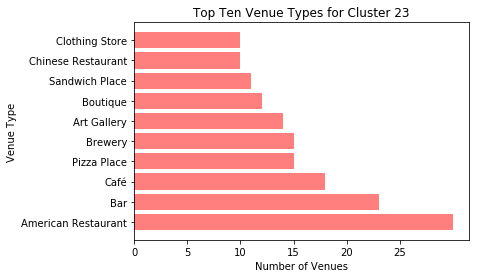

In [51]:
Y = list(cluster_23_counts_t.index)
X = cluster_23_counts_t['Count']

x_pos = np.arange(0, max(X), 5)

plt.barh(Y, X, align='center', alpha=0.5, color="#ff0000")
plt.xticks(x_pos)
plt.xlabel('Number of Venues')
plt.ylabel('Venue Type')
plt.title('Top Ten Venue Types for Cluster 23')

plt.show()

**Cluster 44 Top Ten Bar Graph**

In [52]:
cluster_44_counts_t = cluster_44_counts.T
cluster_44_counts_t.rename(columns={0:"Count"}, inplace=True)
cluster_44_counts_t.sort_values(by=['Count'], ascending=False, inplace=True)
cluster_44_counts_t = cluster_44_counts_t.head(10)

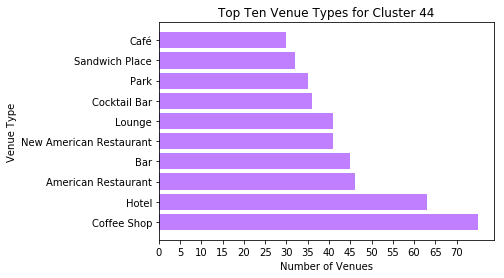

In [53]:
Y = list(cluster_44_counts_t.index)
X = cluster_44_counts_t['Count']

x_pos = np.arange(0, max(X), 5)

plt.barh(Y, X, align='center', alpha=0.5, color="#8000ff")
plt.xticks(x_pos)
plt.xlabel('Number of Venues')
plt.ylabel('Venue Type')
plt.title('Top Ten Venue Types for Cluster 44')

plt.show()

**Cluster 78 Top Ten Bar Graph**

In [54]:
cluster_78_counts_t = cluster_78_counts.T
cluster_78_counts_t.rename(columns={0:"Count"}, inplace=True)
cluster_78_counts_t.sort_values(by=['Count'], ascending=False, inplace=True)
cluster_78_counts_t = cluster_78_counts_t.head(10)

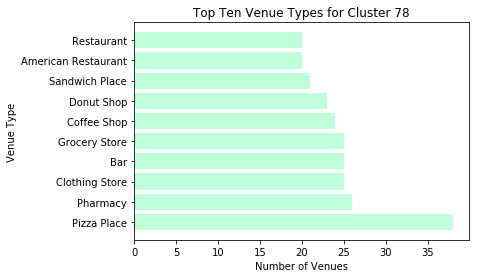

In [55]:
Y = list(cluster_78_counts_t.index)
X = cluster_78_counts_t['Count']

x_pos = np.arange(0, max(X), 5)

plt.barh(Y, X, align='center', alpha=0.5, color="#80ffb4")
plt.xticks(x_pos)
plt.xlabel('Number of Venues')
plt.ylabel('Venue Type')
plt.title('Top Ten Venue Types for Cluster 78')

plt.show()

### In the code blocks below, bar charts are generated for income and house value in each cluster by city.  This should help stakeholders visualize the differences in this key demographic data. ###

**Housing and Income Data Charts for Clusters**

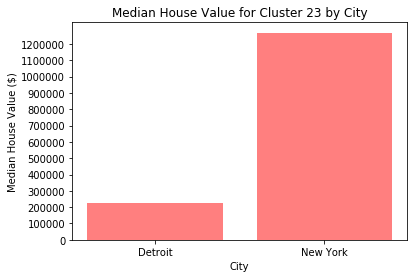

In [56]:
Y = list(cluster23.groupby('City')['Median House Value'].mean().round(2))
X = ['Detroit', 'New York']

y_pos = np.arange(0, max(Y), 100000)

plt.bar(X, Y, align='center', alpha=0.5, color="#ff0000")
plt.yticks(y_pos)
plt.xlabel('City')
plt.ylabel('Median House Value ($)')
plt.title('Median House Value for Cluster 23 by City')

plt.show()

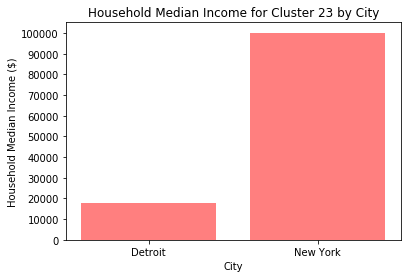

In [57]:
Y = list(cluster23.groupby('City')['Household Median Income'].mean().round(2))
X = ['Detroit', 'New York']

y_pos = np.arange(0, max(Y), 10000)

plt.bar(X, Y, align='center', alpha=0.5, color="#ff0000")
plt.yticks(y_pos)
plt.xlabel('City')
plt.ylabel('Household Median Income ($)')
plt.title('Household Median Income for Cluster 23 by City')

plt.show()

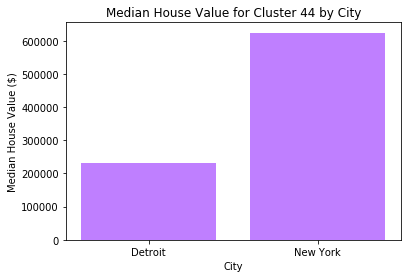

In [58]:
Y = list(cluster44.groupby('City')['Median House Value'].mean().round(2))
X = ['Detroit', 'New York']

y_pos = np.arange(0, max(Y), 100000)

plt.bar(X, Y, align='center', alpha=0.5, color="#8000ff")
plt.yticks(y_pos)
plt.xlabel('City')
plt.ylabel('Median House Value ($)')
plt.title('Median House Value for Cluster 44 by City')

plt.show()

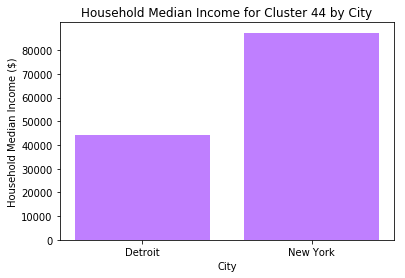

In [59]:
Y = list(cluster44.groupby('City')['Household Median Income'].mean().round(2))
X = ['Detroit', 'New York']

y_pos = np.arange(0, max(Y), 10000)

plt.bar(X, Y, align='center', alpha=0.5, color="#8000ff")
plt.yticks(y_pos)
plt.xlabel('City')
plt.ylabel('Household Median Income ($)')
plt.title('Household Median Income for Cluster 44 by City')

plt.show()

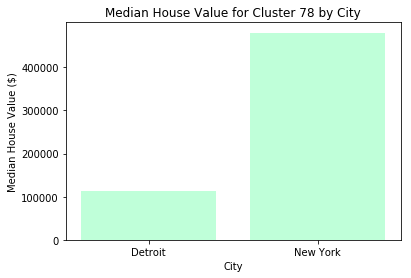

In [60]:
Y = list(cluster78.groupby('City')['Median House Value'].mean().round(2))
X = ['Detroit', 'New York']

y_pos = np.arange(0, max(Y), 100000)

plt.bar(X, Y, align='center', alpha=0.5, color="#80ffb4")
plt.yticks(y_pos)
plt.xlabel('City')
plt.ylabel('Median House Value ($)')
plt.title('Median House Value for Cluster 78 by City')

plt.show()

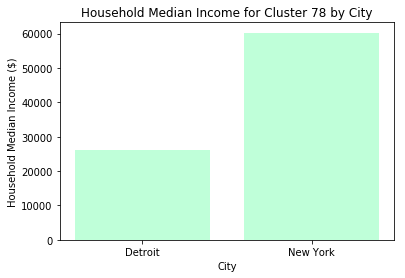

In [61]:
Y = list(cluster78.groupby('City')['Household Median Income'].mean().round(2))
X = ['Detroit', 'New York']

y_pos = np.arange(0, max(Y), 10000)

plt.bar(X, Y, align='center', alpha=0.5, color="#80ffb4")
plt.yticks(y_pos)
plt.xlabel('City')
plt.ylabel('Household Median Income ($)')
plt.title('Household Median Income for Cluster 78 by City')

plt.show()

**Target Business examples:** Now, let's generate a list of ten target New York businesses from each clusters.  These are not recommendations, but only examples to give stakeholders a flavor of what kind of businesses the may attract.  These businesses do not have to be a "top ten" type of business in a cluster, only an existing one.

In [80]:
import random # Use this library to help randomly selecting target businesses examples

*Cluster 23 Examples*

In [92]:
venret_df = cluster23_display[cluster23_display['City'] == 'New York']
tmpven_23 = pd.DataFrame(columns=['City', 'Borough', 'Neighborhood', 'Venue','Venue Category'])

for cit, bor, nhood in zip(venret_df['City'], venret_df['Borough'], venret_df['Neighborhood']):
    temptemp = Venues_df[(Venues_df['City'] == cit) & (Venues_df['Borough'] == bor) & (Venues_df['Neighborhood'] == nhood)][['City', 'Borough', 'Neighborhood', 'Venue','Venue Category']]
    tmpven_23 = pd.concat([tmpven_23, temptemp], ignore_index=True, sort=False)


In [98]:
randomlist = random.sample(range(0, tmpven_23.shape[0]), 10)
select_23 = pd.DataFrame(columns=['City', 'Borough', 'Neighborhood', 'Venue','Venue Category'])

for rand_row in randomlist:
    select_23 = select_23.append(tmpven_23.iloc[rand_row], ignore_index=False, sort=False)
select_23

,City,Borough,Neighborhood,Venue,Venue Category
43,New York,Brooklyn,Red Hook,Kevin's,Seafood Restaurant
10,New York,Brooklyn,Red Hook,Pioneer Works,Event Space
20,New York,Brooklyn,Red Hook,Record Shop,Record Shop
32,New York,Brooklyn,Red Hook,Red Hook Labs,Art Gallery
3,New York,Brooklyn,Red Hook,Court Street Grocers Hero Shop,Sandwich Place
2,New York,Brooklyn,Red Hook,Baked,Bakery
18,New York,Brooklyn,Red Hook,Sixpoint Brewery,Brewery
23,New York,Brooklyn,Red Hook,The Black Flamingo,Café
25,New York,Brooklyn,Red Hook,WOODEN SLEEPERS,Clothing Store
33,New York,Brooklyn,Red Hook,Reed Park,Seafood Restaurant


*Cluster 44 Examples*

In [94]:
venret_df = cluster44_display[cluster44_display['City'] == 'New York']
tmpven_44 = pd.DataFrame(columns=['City', 'Borough', 'Neighborhood', 'Venue','Venue Category'])

for cit, bor, nhood in zip(venret_df['City'], venret_df['Borough'], venret_df['Neighborhood']):
    temptemp = Venues_df[(Venues_df['City'] == cit) & (Venues_df['Borough'] == bor) & (Venues_df['Neighborhood'] == nhood)][['City', 'Borough', 'Neighborhood', 'Venue','Venue Category']]
    tmpven_44 = pd.concat([tmpven_44, temptemp], ignore_index=True, sort=False)


In [114]:
randomlist = random.sample(range(0, tmpven_44.shape[0]), 10)
select_44 = pd.DataFrame(columns=['City', 'Borough', 'Neighborhood', 'Venue','Venue Category'])

for rand_row in randomlist:
    select_44 = select_44.append(tmpven_44.iloc[rand_row], ignore_index=False, sort=False)
select_44

,City,Borough,Neighborhood,Venue,Venue Category
157,New York,Manhattan,Hudson Yards,Uncle Jack's Steakhouse,Steakhouse
173,New York,Queens,Queensbridge,Queensboro Bridge Pedestrian & Bike Path,Scenic Lookout
166,New York,Manhattan,Hudson Yards,George's,Burger Joint
19,New York,Manhattan,Midtown South,Samwon Garden BBQ,Korean Restaurant
74,New York,Manhattan,Midtown South,Made Nice,Restaurant
116,New York,Manhattan,Hudson Yards,Baryshnikov Arts Center,Theater
67,New York,Manhattan,Midtown South,Five Senses,Korean Restaurant
167,New York,Manhattan,Hudson Yards,Jake's,American Restaurant
18,New York,Manhattan,Midtown South,Louis Vuitton,Boutique
101,New York,Manhattan,Midtown South,Take 31,Korean Restaurant


*Cluster 78 Examples*

In [96]:
venret_df = cluster78_display[cluster78_display['City'] == 'New York']
tmpven_78 = pd.DataFrame(columns=['City', 'Borough', 'Neighborhood', 'Venue','Venue Category'])

for cit, bor, nhood in zip(venret_df['City'], venret_df['Borough'], venret_df['Neighborhood']):
    temptemp = Venues_df[(Venues_df['City'] == cit) & (Venues_df['Borough'] == bor) & (Venues_df['Neighborhood'] == nhood)][['City', 'Borough', 'Neighborhood', 'Venue','Venue Category']]
    tmpven_78 = pd.concat([tmpven_78, temptemp], ignore_index=True, sort=False)


In [120]:
randomlist = random.sample(range(0, tmpven_78.shape[0]), 10)
select_78 = pd.DataFrame(columns=['City', 'Borough', 'Neighborhood', 'Venue','Venue Category'])

for rand_row in randomlist:
    select_78 = select_78.append(tmpven_78.iloc[rand_row], ignore_index=False, sort=False)
select_78

,City,Borough,Neighborhood,Venue,Venue Category
158,New York,Bronx,Hunts Point,the point cafe & grill,Café
695,New York,Queens,Sunnyside Gardens,Ida's Nearabout,Bar
160,New York,Bronx,Hunts Point,H. Weiss Machinery & Supply,Construction & Landscaping
761,New York,Queens,Sunnyside Gardens,Boston Market,American Restaurant
292,New York,Manhattan,Central Harlem,ACP Coffee,Café
309,New York,Manhattan,Central Harlem,Pizza Stop,Pizza Place
304,New York,Manhattan,Central Harlem,Presto Fresh Cafe,Cafeteria
206,New York,Brooklyn,Brighton Beach,Домашняя кухня,Eastern European Restaurant
775,New York,Queens,Sunnyside Gardens,Paddy Duggans,Bar
545,New York,Brooklyn,Ditmas Park,Island Express,Caribbean Restaurant


### Cluster 23 Analysis ###

The top 10 venue types for Cluster 23 primarily consist of eating establishments, bars, clothing stores and art galleries.  From a qualitative perspective, this appears to be a residential kind of area with an active social scene.  One can imagine people living and working in these areas, walking around and shopping during the days, and going out to restaurants and bars at night.

It’s clear from the summary table above that the Cluster 23 New York profile is a little older and with a larger household than in Detroit.  The demographics also show that the income and house value in New York is approximately 5.6 times greater than in Detroit.  

This information can be viewed many ways, but one perspective for people looking to attract business to Detroit is that Cluster 23 New Yorkers who move to Detroit will experience a lower cost of living for themselves and a lower cost of labor for their businesses.  

The following are a randomly selected list of Cluster 23 New York businesses that could be targeted to move to a Cluster 23 neighborhood in Detroit.  These are only examples, not recommendations, and some may not be appropriate to move to Detroit or may already exist in Detroit (such as a chain store).  In addition, targeted businesses do not need to come from the “top 10” business types in a cluster.  Any business that thrives in a cluster could be targeted to move another neighborhood in the same cluster.


### Cluster 44 Analysis ###

Based on the top 10 venue types, Cluster 44 looks like a group of neighborhoods where people go to spend a weekend or have a night out.  Most of the establishments are bars and restaurants, with hotels and parks as well.  These are places people may go for recreation typically.  These neighborhoods may have other significant features that don’t show up in the activities of Foursquare users.

As we Cluster 23, Cluster 44 shows that the New York part of the cluster is older with a larger household.  However, in Cluster 44 the median level of income for Detroit is ½ that of New York while the Detroit house value is 1/3rd that of New York.  The community leaders in Detroit can argue that Cluster 44 New Yorkers who move to Detroit will not only get a lower cost of living and cost of labor, but will also spend less of their income on housing.

### Cluster 78 Analysis ###

Cluster 78 looks primarily like a residential cluster of neighborhoods.  It includes a variety of quick-stop eating places, as well as pharmacies, clothing stores and grocery stores.  This is what you would expect to see in an area that is substantially residential within an urban setting.

Unlike Clusters 23 and 44, the age difference in Cluster 78 is small, with both the median age in New York and Detroit in the late 30’s.  New York’s household is also only slightly larger than Detroit’s.  The income and house value profile of Cluster 78 is very similar to Cluster 44, with New York incomes approximately twice that of Detroit, but New York house values being more than 4 times greater than in Detroit.  As with Cluster 44, community leaders in Detroit can argue that New Yorkers who move will get a lower cost of living and cost of labor, and may also spend less of their income on housing.

## Discussion <a name="discussion"></a>

The goal of this project was to identify similar neighborhoods between Detroit and New York City, based on the business information provided by the Foursquare API.  Using the K-means clustering algorithm described above, three clusters were identified containing both Detroit and New York neighborhoods.  Cluster 23 included neighborhoods that were residential but with many venues for social activities.  Cluster 44 was characterized by venues a person might go to on a night out or on a weekend.  Lastly, Cluster 78 appeared to be populated by purely urban residential neighborhoods.

The demographics between the New York neighborhoods and their Detroit counterparts, showed that New York was slightly older, with much higher levels of income and house values.  In a broad sense, this could be translated into Detroit having a lower cost of living and cost of labor.  Many New Yorkers may be turned off by Detroit’s lower numbers, but some percentage of them may be attracted to them. 

This project has identified 25 New York City neighborhoods that community leaders in Detroit can target for attracting new businesses to the city of Detroit.  Community leaders could target business owners and other people in these neighborhoods directly, through television ads, through social media, or any number of other ways.  Regardless of the method of contact, there is some value in having a narrow focus on where to direct your efforts.

This project, of course, has many limitations.  First, it relies heavily on Foursquare API data to do the clustering, which limits business data to those places frequented by Foursquare users.  In a broader project, a more robust business dataset would be better, perhaps incorporating non-business data as well.  The demographic data used in this project does not have very much depth, and should be viewed primarily has a beginning point for analysis.  The K-means clustering algorithm was not necessarily optimized, however, it did appear to deliver a small set of clusters with meaningfully related neighborhoods, so that should be seen as a success.  Lastly, the full task of attracting people to a new city is multi-dimensional and well beyond the scope of this project.  Other factors, such as tax policy, local politics, school systems, among other things, also matter tremendously.   This project is intended to be only a small piece of that puzzle for the interested parties and stakeholders to utilize.


## Conclusion <a name="conclusion"></a>

Attracting new people and businesses to a city that is shrinking economically is a difficult task that needs to take a multi-faceted approach.  One aspect of that approach is to narrow the focus of who you can attract to the city.  Broad-based, generic approaches are unlikely to be very successful, particularly in an age where people and business are receiving advertisements and other content that are personalized to them.  While this project is small in scope, the hope is that the people tasked with growing the City of Detroit utilize the underlying principles of using sophisticated data modeling and analytics to specifically target new growth.  The success or failure of Detroit’s growth initiatives will be evident many years in the future, but that future will be determined by what people do now.